# Forecasting steel and iron ore prices using Fbprophet Python Library
## Introduction
China’s steel market has been very volatile in the past several years. It is inherently difficult to forecast commodities prices, particularly in the post-pandemic environment but in the case of steel and iron ore (the main material used in steel production), this task is even harder for a few reasons.

Firstly, China’s government has embarked on a de-carbonization journey which resulted in steel production cuts and capacity replacements, particularly in the highly polluted industrial areas of Tangshan. Since January 2021, there have been many announcements from the government and official media confirming China’s plans to become carbon neutral by 2060. Some of the announced measures were addressed directly at the steel industry which has already undergone major transformations including mergers and acquisitions and other structural adjustments like shutting down outdated capacities and plans to introduce green technology like hydrogen and carbon capturing.

Secondly, China has been struggling with some structural challenges in the property market. A combination of zero-covid rules, a slowdown in real estate, and environmental production cuts have been hurting steel demand for the better part of last year. However, last month China’s government announced 16 measures to revive the housing market. The measures among other things aim to provide financial support for viable construction developments, resume stalled projects and help mortgage holders. Although the new property policies do a lot to address the problem, they may not help solve the main issue of the little trust China’s buyers have in real-estate developers.

Thirdly, protectionists policies in various countries across the world are becoming a more prominent feature of the governments’ economic plans. This results in high tariffs imposed on steel products from China. Lastly, the tragic events in Ukraine do not only cost lives in the region and energy crisis in Europe but also threaten economic stability in the rest of the world by reshaping supply chains and causing a major supply crisis.

All the above must be considered in qualitative price forecasting as these developments define fundamentals. One might argue that in such an environment qualitative approach should be the only way. However, on the other hand, predicting the outcome of these uncertainties is extremely difficult and time series forecasting could still be useful in certain circumstances.

## Hypothesis 

It has been written a lot on the topic of time series forecasting. The purpose of this article is to describe the process used in our model which employs [fbprophet](https://facebook.github.io/prophet/) Python library (Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.) to forecast the price of HRC steel prices in China and iron ore 62% Fe content CFR China prices.

There are multiple reasons why the Fbprophet Python library could be a good fit for our forecast modeling:

1. It works well with stationary time series where non-linear trends follow some type of seasonality (weekly, yearly, daily).
2. Fbprophet requires several cycles of such seasonality to be observed in the historical time series
3. Fbprophet is relatively robust with shifts in data trends and deals well with outliers.

### Step by Step Process
Import necessary libraries to be used.

In [1]:
import eikon as ek
from fbprophet import Prophet
import statsmodels.api as sm
import numpy as np
import pandas as pd
import datetime
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

To start with we load RICs and prepare data for further analysis.

In [2]:
# Load RICs
ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY')
sd = datetime.date(day = 1, month = 1, year = 2018).strftime('%d-%m-%Y')
ed = datetime.date.today().strftime('%d-%m-%Y')
a_interval = 'daily'

ric_names = ['SH-CCN-IRNOR62','SH-WUH-3HRCOIL']
rics = {}

def get_timeseries(ric):
    print(f'Getting timeseries data of {ric}')
    df = ek.get_timeseries(ric, start_date = sd, interval = a_interval)
    df.columns.values[0] = 'Value'
    df['Date'] = pd.to_datetime(df.index)    
    df['Price'] = df['Value']
    rics[ric] = df
    
    
for ric in ric_names:
    get_timeseries(ric)

Getting timeseries data of SH-CCN-IRNOR62
Getting timeseries data of SH-WUH-3HRCOIL


In [3]:
# Prep Data
ric_prep = {}
def prep_data(ric):
    this_ric = rics[ric]
    this_ric['Price'] = this_ric['Price'].apply(lambda x:float(x)) # Price values as float
    this_ric = this_ric.resample('D').mean() # resample for daily
    this_ric['Date_Day'] = this_ric.index
    this_ric['Date_Day'] = this_ric['Date_Day'].dt.strftime('%Y-%m-%d').copy() # changing Date format

    holidays = this_ric[this_ric['Price'].isin([np.nan])] # saving holidays and weekends for further predictions in prophet
    holidays = holidays.Date_Day.tolist()
    holidays_df = pd.DataFrame({'holiday' : 'weekend', 'ds' : pd.to_datetime(holidays)})

    this_ric['Price'] = this_ric['Price'].fillna(method='ffill') # replacing gaps in values
    this_ric = this_ric.reset_index(drop=True)
    
    ric_prep[ric] = this_ric
    return holidays_df


for ric in rics:
    holidays_df = prep_data(ric)
print('Done Loading RICs...')

Done Loading RICs...


Secondly, we perform [Augmented Dickey-Fuller Test](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/) (ADF) to check whether our data is stationary/non-stationary. Using the ___diff()___ function will allow us to calculate the first-order difference in the selected time series with a predefined shift period. The shift period is defined as a parameter __period__. We then test the resulting row of data for stationarity/non-stationarity and print the test statistics as per the method below.

In [4]:
# Augmented Dickey-Fuller Test
def adf_test(ric):
    ric_adf = ric_prep[ric].copy()
    vals = ric_adf.Price
    diff = vals.diff(periods=1).dropna()
    test = sm.tsa.adfuller(diff)
    print('adf:',test[0])
    print('====> p-value:',test[1])
    print('Critical values:',test[4])
    if test[0] > test[4]['5%']:
        print(f'{ric} non stationary')
    else:
        print(f'{ric} stationary! The row of first differences is stationary and the initial row is an integrated row of the first order')
        
        
for ric in ric_prep:
    adf_test(ric)
print('done ADF Test...')

adf: -21.404872748901784
====> p-value: 0.0
Critical values: {'1%': -3.433926456232207, '5%': -2.863119805756803, '10%': -2.5676110344808043}
SH-CCN-IRNOR62 stationary! The row of first differences is stationary and the initial row is an integrated row of the first order
adf: -9.09112259902564
====> p-value: 3.821856158152293e-15
Critical values: {'1%': -3.4339580289794225, '5%': -2.8631337437669275, '10%': -2.567618456010139}
SH-WUH-3HRCOIL stationary! The row of first differences is stationary and the initial row is an integrated row of the first order
done ADF Test...


After performing the stationarity check, we need to define the model’s characteristics and “tune it” so to speak. We define the prediction period as a __period__ of 30 days (this could be increased). We then create __ds__ (date as DateTime) and __y__ (values that we are going to predict) columns. We will then convert the Price column into a log value. In statistical analysis, logging helps to convert multiplicative relationships between datapoints into additive relationships, and converts exponential (compound growth) trends into linear trends. Therefore, by taking logarithms of values which are multiplicatively related we can explain their behaviour with a linear model.

We are taking data (except for the last 30 values) for training our model in order to compare the actual values in our time series with the 30 values predicted by the model

```ric_train = ric[:-period]```

We create the model, using the __fit__ method, and get the prognosis. It is worth mentioning that Fbprophet is a very flexible and easy-to-train model. Very often the quality of the forecast depends on the time series' characteristics as well as the model’s parameters that can be defined (and tuned) depending on our knowledge about the time series and multiple rounds of testing. These parameters include:

- __Interval_width:__ the width of the uncertainty intervals
- __N_changepoints:__ changepoints are the DateTime points where the time series have sudden changes in the trajectory (there is a full list of changepoints in prophet which are accessible using ch_points = pr_model.changepoints)
- __Changepoints_prior_scale:__ helps adjust the strength of the trend. It is possible to increase the value of changepoints_prior_scale to make the trend more flexible
- __Changepoints_range:__ the range of historical data points (starting from the first observation) within which the changepoints in trend will be assessed
- __Yearly, weekly and daily seasonality:__ self-explanatory parameters that we can set as true or false for our time series
- __Holidays:__ we can create a custom holiday list by creating a data frame with two columns ds and holiday

For predictions, we need to create a data frame with ds (DateTime) containing the dates for which we want to create a forecast. We are using make_future_dataframe() where we specify prediction dates. We then combine actual data and our forecast data into one table. It is useful to have a look at __MAE (mean absolute error)__ which helps in understanding how precise the model’s predictions are.

Lastly, we perform the prediction of all available data points within our time series as per the below steps:

In [5]:
# Test Prediction
ric_plot = {}
for ric_name in ric_prep:
    print(f'run Test {ric_name} Predict...')
    period = 30
    ric = ric_prep[ric_name]
    ric = pd.DataFrame({'ds' : ric.Date_Day, 'y' : ric.Price})
    ric['y'] = np.log(ric['y'])
    ric = ric.reset_index(drop=True)
    
    ric_train = ric[:-period]
    pr_model = Prophet(interval_width=0.95, # The width of the uncertainty intervals (by default 80%) can be set using the parameter interval_width
                       n_changepoints=40,
                       changepoint_prior_scale=0.08,
                       changepoint_range=0.09,   
                       yearly_seasonality=True,
                       weekly_seasonality=False,
                       daily_seasonality=False,
                       holidays=holidays_df)
    pr_model.fit(ric_train)
    
    future = pr_model.make_future_dataframe(periods = period, freq = 'D') # df for date +30 forecast days
    forecast = pr_model.predict(future)

    forecast['ds'] = forecast['ds'].dt.strftime('%Y-%m-%d').copy()
    cmp_df = forecast.set_index('ds')[['yhat_lower','yhat_upper','yhat']].join(ric.set_index('ds')).copy() #df compare
    cmp_df['MAE'] = cmp_df['y'] - cmp_df['yhat'] # mean absolute error (on average the models error)
    print('MAE', np.mean(abs(cmp_df[-period:]['MAE'])))

    # Prediction
    print(f'run {ric_name} Predict...')
    
    ric = ric_prep[ric_name]
    ric = pd.DataFrame({'ds':ric.Date_Day,'y':ric.Price})
    pr_model = Prophet(interval_width=0.95, # The width of the uncertainty intervals (by default 80%) can be set using the parameter interval_width
                       n_changepoints=40, # 25 by default
                       changepoint_prior_scale=0.08, # 0.05 by default
                       changepoint_range=0.09,   # 0.8 by default
                       yearly_seasonality=True,
                       weekly_seasonality=False,
                       daily_seasonality=False,
                       holidays=holidays_df)

    ric['y'] = np.log(ric['y']) 
    ric = ric.reset_index(drop=True)
    pr_model.fit(ric)
    future = pr_model.make_future_dataframe(periods = period, freq = 'D')
    forecast = pr_model.predict(future)

    ric['y'] = np.exp(ric['y']) #converting back into numerical values 
    forecast['yhat_lower'] = np.exp(forecast['yhat_lower'])
    forecast['yhat_upper'] = np.exp(forecast['yhat_upper'])
    forecast['yhat'] = np.exp(forecast['yhat']) 

    forecast['ds'] = forecast['ds'].dt.strftime('%Y-%m-%d').copy() #creating a table with actual data and predictions 
    prophet_ric = pd.DataFrame({'Date':forecast.ds,'Price':forecast.yhat})
    prophet_ric = prophet_ric.tail(period).copy()

    ric = ric.rename(columns={'ds':'Date','y':'Price'}) #renaming back our columns as date and price
    ric = pd.concat([ric, prophet_ric])
    ric = ric.reset_index(drop=True)
    ric_plot[ric_name] = ric
    print(f'done {ric_name} Predict...')

run Test SH-CCN-IRNOR62 Predict...
Initial log joint probability = -4.55134
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4937.44   0.000893008        337.88           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4938.1    0.00046357       201.644           1           1      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4938.33   0.000265152       86.6697           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       4938.38   1.24775e-05       87.5209   1.173e-07       0.001      432  LS failed, Hessian reset 
     399       4938.49    0.00132202       88.9428           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

As a final step we are plotting our data and predictions in plotly

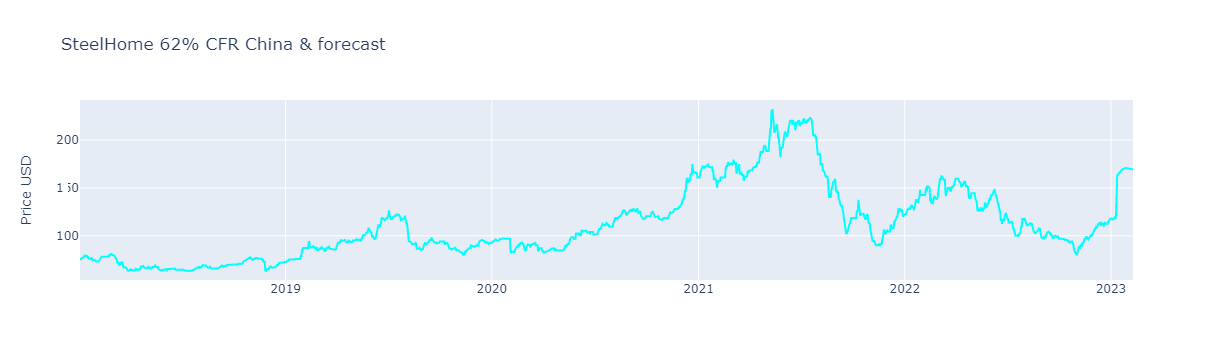

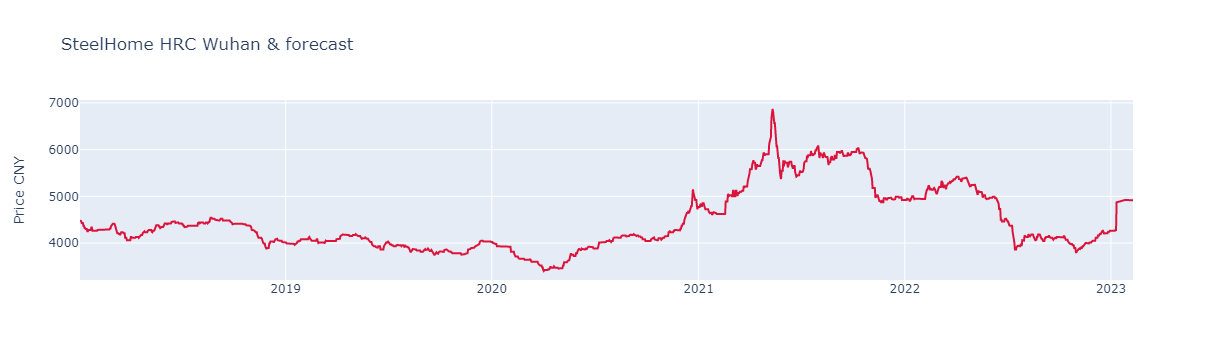

Finish


In [9]:
# Plot
for ric_name in ric_plot:
    if ric_name == 'SH-CCN-IRNOR62':
        color = 'cyan'
        title_text = 'SteelHome 62% CFR China & forecast'
        yaxis_title = 'Price USD'
    elif ric_name == 'SH-WUH-3HRCOIL':
        color = 'crimson'
        title_text = 'SteelHome HRC Wuhan & forecast'
        yaxis_title = 'Price CNY'
    else:
        color = ''
        title_text = ''
        yaxis_title = ''
    
    ric = ric_plot[ric_name]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ric.Date.values, y=ric.Price.values, name=ric_name, line=dict(color=color)))
    start_pred = ric.head(1).reset_index(drop = True).loc[0, 'Date']
    fig.update_layout(title_text=title_text, yaxis_title=yaxis_title)
    fig.show()
    
print('Finish')

# Conclusion
This article demonstrates how the Fbprophet Python Library can be used in price forecast modelling using an example of Hot Rolled Coil (HRC) steel price in China and iron ore 62% Fe content CFR China. The prices’ historical data and predictions are plotted as a graph with Plotly Python library as a visualisation to help with analysing price trends and a potential direction the prices may take in the short-term future.